In [310]:
import pandas as pd 
import re
from textblob import TextBlob

import seaborn as sns 
import matplotlib.pyplot as plt

#nltk.download('stopwords')
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer

In [13]:
path = 'rawdata/PC.tsv.gz'
raw_df = pd.read_csv(path,sep='\t', on_bad_lines='skip')

# 1 Preprocessing 

In [225]:
# 1.1 only get total_votes >= 40
df = raw_df[raw_df['total_votes'] >= 40]

# 1.2 Removing Nulls & duplicate
df = df.dropna()

# 1.3 Preparing columns 
df['review'] = df['review_headline'] + ", " + df['review_body']
df = df.drop(['review_headline', 'review_body'], axis=1)
df = df.drop_duplicates(subset=['review'])

# vote ratio => label
df['vote_ratio'] = df['helpful_votes'] / df['total_votes']
df = df.drop(['helpful_votes', 'total_votes'], axis=1)

threshold = 0.8
df['helpfulness'] = [1 if x >= threshold else 0 for x in df['vote_ratio']]

# verified purchase to 1 0
df['verified_purchase'] = [1 if x == 'Y' else 0 for x in df['verified_purchase']]
df['vine'] = [1 if x == 'Y' else 0 for x in df['vine']]
df['sentence_count'] = df.apply(lambda row: sent_tokenize(row['review']), axis=1).apply(lambda x: len(x))
df = df.reset_index(drop=True)

In [226]:
html_cleaner = re.compile('<.*?>')
def eliminate_html(reviews):
    reviews_nohtml = re.sub(html_cleaner, "", reviews)
    return reviews_nohtml

df['review'] = df.apply(lambda x: preprocess(x['review']), axis=1)
# find review length 
df['reivew_len'] = df.apply(lambda x: len(x['review']), axis=1)
# add sentiment polairty score to each review using TextBlob 
df['polarity'] = df.apply(lambda x: TextBlob(x['review']).sentiment.polarity, axis=1)

To check if the polarity score represents the sentiments of reviews, we can print five reviews with the highest polarity score, 1, and five reviews with the lowest polarity score, -1.

In [195]:
positive_review_samples = df.loc[df['polarity'] == 1, 'review'].sample(5).values 
for i in range(len(positive_review_samples)):
    print("sentence #{} : {}".format((i + 1), positive_review_samples[i]))

sentence #1 : awesome, just got the flash drive today and ran a benchmark. the speeds on this are impressive for the money. the cover the for the flash drive is built in and cant get lost which is a bonus for me.
sentence #2 : The Perfect MacBook Air Messenger Bag, [[VIDEOID:mo1ASZ1HXSWUNYK]]This video is a demo and recommendation for the Targus Vertical Messenger bag which I purchase on Amazon.
sentence #3 : Three Stars, Looks like they need to replace &#34;Add to Cart&#34; button with &#34;I'm Feeling Lucky&#34; for this reader :D
sentence #4 : Copystar DVD Duplicator, This product is excellent.  Just plug it in and go.  Burns DVDs in minutes. I have had no problems at all with it.
sentence #5 : Best Macbook to date, [[VIDEOID:mo3FDXRV7326VFY]]


In [196]:
negative_review_samples = df.loc[df['polarity'] == -1, 'review'].sample(5).values 
for i in range(len(negative_review_samples)):
    print("sentence #{} : {}".format((i + 1), negative_review_samples[i]))

sentence #1 : DO NOT BUY A DELL!!, Junk!! 2 Dells over the lastb 2 years the harddrive crashed. Both XPSs. DO NOT BUY A DELL!! And customer service is terrible! Unless you like curry!!!
sentence #2 : AWFUL, AWFUL
sentence #3 : horrible, Horrible! This is horrible I'm sticking with pc.
sentence #4 : One Star, Sucks!!!! Can't do s*** with this computer. I should of researched it before wasting money!! 😡😡😡😡
sentence #5 : One Star, This is the worst system ever. I wouldn't even recommend buying this for scrap parts. I HATE IT!


From the result, we can see that polarity score performs well on positive and negative reviews.

# 2 Text Visualization

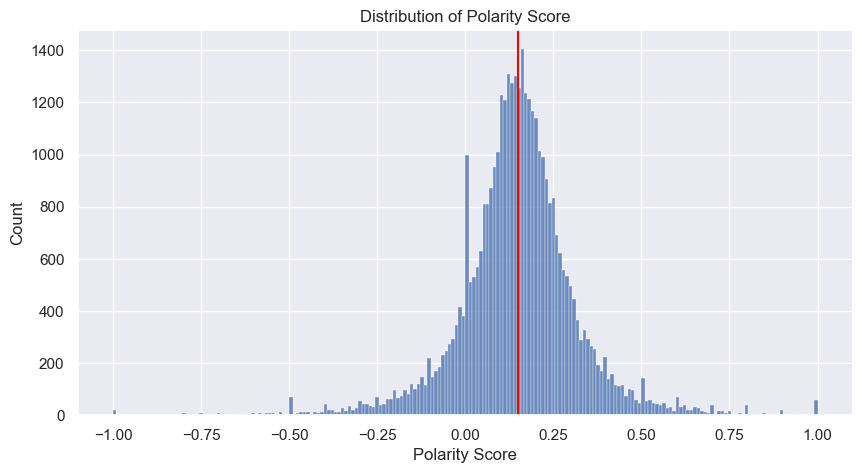

In [239]:
# 2.1 distribution of polarity score 
sns.set(rc={"figure.figsize":(10, 5)})
ax = sns.histplot(data=df, x="polarity", alpha=0.8)
plt.xlabel("Polarity Score")
plt.title("Distribution of Polarity Score")
plt.axvline(x=df.polarity.mean(), color="red")
plt.show()

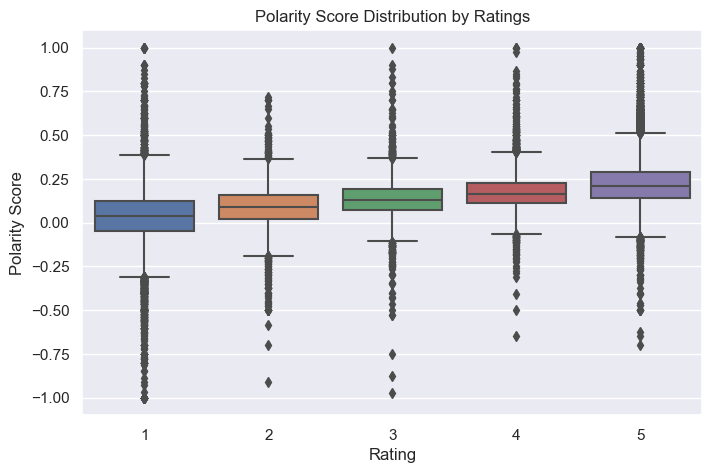

In [242]:
# 2.2 Polarity Score Distribution by Ratings
sns.set(rc={"figure.figsize":(8,5)})
ax = sns.boxplot(data=df, x="star_rating", y="polarity")
plt.xlabel("Rating")
plt.ylabel("Polarity Score")
plt.title("Polarity Score Distribution by Ratings")
plt.show()

It can be seen from Figure 2.2 that when customers give a high rating to a product, the sentiment in their reviews is more positive.

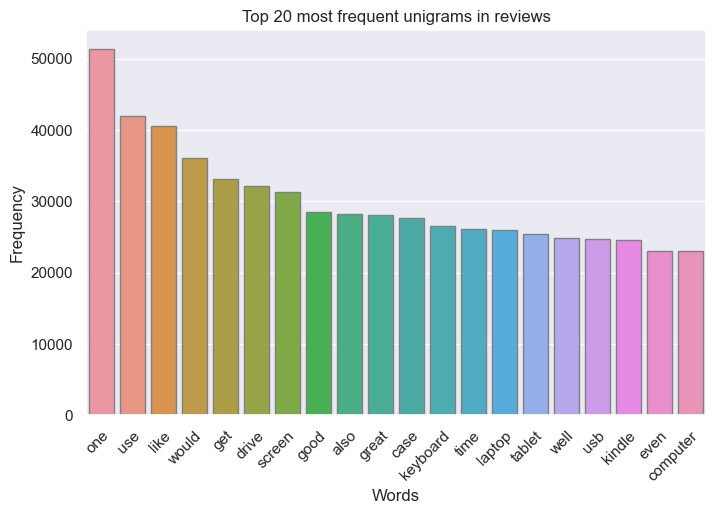

In [330]:
# 2.3 Top unigrams after removing stop words 
def get_top_n_words(corpus, n=None, n_gram=(1,1)):
    '''
    Description: finding most common words with number of appearance 
    Author: Cristhian Boujon
    URL: https://medium.com/@cristhianboujon/how-to-list-the-most-common-words-from-text-corpus-using-scikit-learn-dad4d0cab41d
    '''
    vec = CountVectorizer(ngram_range=n_gram, stop_words = stopwords.words('english')).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

top_20_unigrams = get_top_n_words(df['review'], 20)
unigrams_df = pd.DataFrame(top_20_unigrams, columns = ['review', 'count'])

sns.set(rc={"figure.figsize":(8,5)})
ax = sns.barplot(data=unigrams_df, x='review', y='count', edgecolor='.5')
ax.set_xticklabels(unigrams_df['review'], rotation=45, ha='right', rotation_mode='anchor')
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.title("Top 20 most frequent unigrams in reviews")
plt.show()

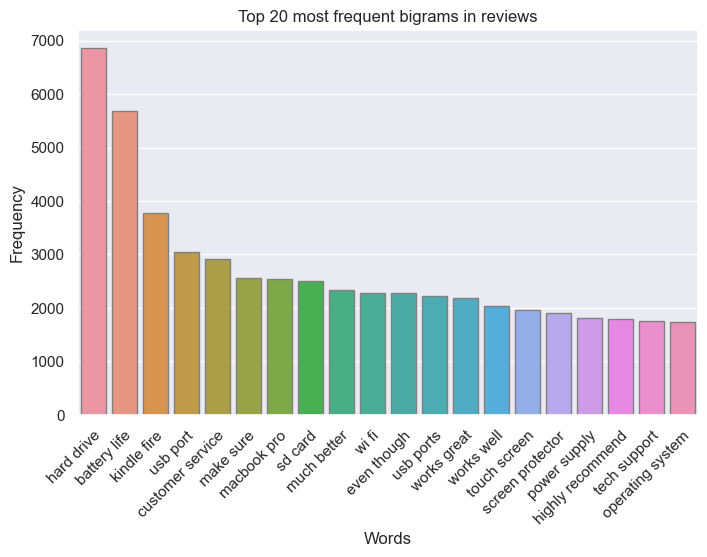

In [331]:
# 2.4 Top bigrams after removing stop words 
top_20_bigrams = get_top_n_words(df['review'], 20, (2,2))
bigrams_df = pd.DataFrame(top_20_bigrams, columns = ['review', 'count'])

sns.set(rc={"figure.figsize":(8,5)})
ax = sns.barplot(data=bigrams_df, x='review', y='count', edgecolor='.5')
ax.set_xticklabels(bigrams_df['review'], rotation=45, ha='right', rotation_mode='anchor')
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.title("Top 20 most frequent bigrams in reviews")
plt.show()

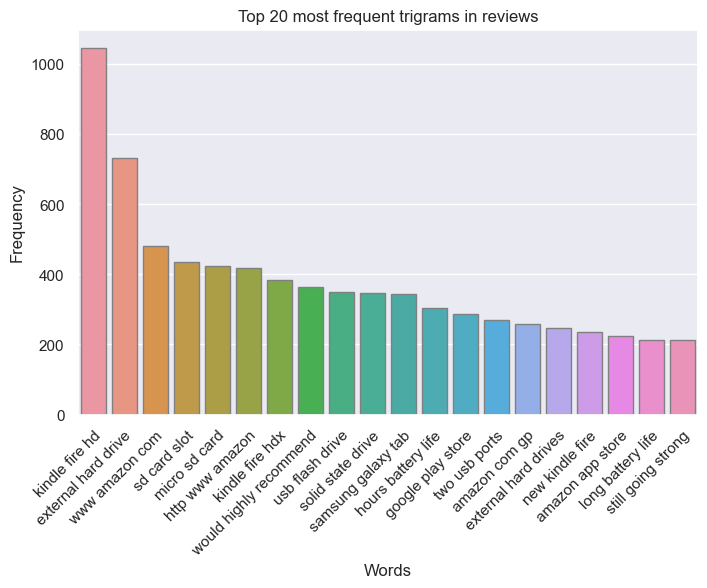

In [333]:
# 2.5 Top trigrams after removing stop words 
top_20_bigrams = get_top_n_words(df['review'], 20, (3,3))
bigrams_df = pd.DataFrame(top_20_bigrams, columns = ['review', 'count'])

sns.set(rc={"figure.figsize":(8,5)})
ax = sns.barplot(data=bigrams_df, x='review', y='count', edgecolor='.5')
ax.set_xticklabels(bigrams_df['review'], rotation=45, ha='right', rotation_mode='anchor')
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.title("Top 20 most frequent trigrams in reviews")
plt.show()

In [334]:
# reference
# https://medium.com/@cristhianboujon/how-to-list-the-most-common-words-from-text-corpus-using-scikit-learn-dad4d0cab41d
# https://towardsdatascience.com/a-complete-exploratory-data-analysis-and-visualization-for-text-data-29fb1b96fb6a